# Thompson Sampling for Linearly Constrained Bandits 
## Finite-Time Regret and Violation Performance

In [1]:
import ray
import time

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 22, 'lines.linewidth' : 3})

ray.init(redis_address="172.31.15.5", ignore_reinit_error=True)

2019-10-05 22:33:01,109	WARNING worker.py:1354 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.


{'node_ip_address': '172.18.0.15',
 'redis_address': '172.18.0.15:15672',
 'object_store_address': '/tmp/ray/session_2019-10-05_19-22-12_1830/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2019-10-05_19-22-12_1830/sockets/raylet',
 'webui_url': None}

In [2]:
data = pd.read_csv( 'datasets/edX-Course.csv', thousands=',' )

In [3]:
part_rate = data['Participants']
part_rate_normed =  ( part_rate - min( part_rate ) ) / ( max(part_rate) - min( part_rate ) )

cert_rate = data['Certified'] / data['Participants']

Text(0, 0.5, 'Expected Reward')

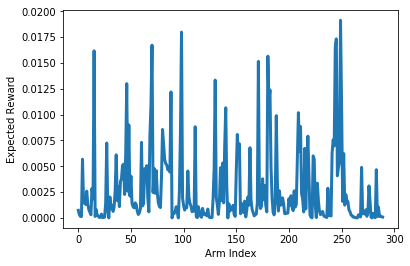

In [7]:
plt.plot( part_rate_normed * cert_rate )

plt.xlabel('Arm Index')
plt.ylabel('Expected Reward')

In [8]:
best_arm = np.argmax( part_rate_normed * cert_rate )

best_arm_expected_reward = part_rate_normed[ best_arm ] * cert_rate[ best_arm ]
best_arm_reward_event_mean = part_rate_normed[ best_arm ]

print( 'Best Arm: %d, Expected Reward %0.4f, Mean Reward Events: %0.2f'%( best_arm, 
                                                                          best_arm_expected_reward, 
                                                                          best_arm_reward_event_mean ) )

Best Arm: 249, Expected Reward 0.0191, Mean Reward Events: 0.21


In [9]:
@ray.remote
def f():
    time.sleep(0.01)
    return ray.services.get_node_ip_address()

# Get a list of the IP addresses of the nodes that have joined the cluster.
ray_node_ips = set(ray.get([f.remote() for _ in range(1000)]))
print('Number of active Ray nodes: %d'%(len(ray_node_ips)))

Number of active Ray nodes: 1


In [10]:
reward_event_mean = part_rate_normed
reward_value = cert_rate

nrof_arms = len( reward_event_mean )

constraint = 0.5

T = 10000
N = 16

In [11]:
class Environment():
    def __init__(self, success_prob):
        self.success_prob = success_prob
         
    def pull(self, arm):
        if np.random.rand() < self.success_prob[arm]:
            return 1 # Success event
        else:
            return 0 # No reward event
            
    # Return the success probability for Oracle and for debugging purposes
    def get_success_prob(self):
        return self.success_prob

# Base Constrained Bandit

In [12]:
from cvxopt import matrix, solvers

# nrof_arms: Number of bandit arms (K)
# reward_value: Reward value for each arm (r_k) if successful
# target_success_prob: Target success probability
# window_size: Window size for sliding window bandit. Events outside the window are discarded
class BaseConstrainedBandit():
    def __init__(self,
                 nrof_arms,
                 reward_value,
                 target_success_prob=0.0):

        self.nrof_arms = nrof_arms
        self.reward_value = reward_value

        self.target_success_prob = target_success_prob

        self.t = 0

        self.pull_count = [0 for _ in range(self.nrof_arms)]
        self.success_count = [0 for _ in range(self.nrof_arms)]

    # Determine which arm to be pulled
    def act(self): # Implemented in child classes
        pass

    # Update the bandit
    def update(self, arm, success):
        self.t += 1

        self.pull_count[arm] += 1
        self.success_count[arm] += success

    # Calculate the selection probability vector by solving a linear program
    def calculate_selection_probabilities(self, success_prob, tolerance=1e-5):
        c = matrix(-1 * np.array(success_prob) * np.array(self.reward_value))

        neg_success_prob = [-1.0 * r for r in success_prob]

        G = matrix(np.vstack([neg_success_prob, -1.0 * np.eye(self.nrof_arms)]))
        h = matrix(np.append(-1 * self.target_success_prob, np.zeros((1, self.nrof_arms))))

        A = matrix(np.ones((1, self.nrof_arms)))
        b = matrix([1.0])

        sol = solvers.lp(c, G, h, A, b, solver='glpk', options={'glpk':{'msg_lev':'GLP_MSG_OFF'}})

        selection_prob = np.reshape(np.array(sol['x']), -1)

        if None in selection_prob: # Unsolvable optimiation
            return [None]

        # Fix numerical issues
        selection_prob[np.abs(selection_prob) < tolerance] = 0.0  # Remove precision-related values
        selection_prob = selection_prob / sum(selection_prob)     # Recalibrate probability vector to sum to 1

        return selection_prob

    # Sample from the probabilistic selection vector
    def sample_prob_selection_vector(self, prob):
        try:
            return np.argwhere(np.random.multinomial(1, prob))[0][0]
        except: # Throws ValueError somtimes
            print('Error thrown by prob sampling. Returning random sample')
            return np.random.randint(0, self.nrof_arms)

# Oracle Constrained Bandit
## Implements the stationary optimal policy

In [13]:
# nrof_arms: Number of bandit arms (K)
# reward_value: Reward value for each arm (r_k) if successful
# target_success_prob: Target success probability
# success_prob: Success probability for each bandit arm
class OracleConstrainedBandit(BaseConstrainedBandit):
    def __init__(self,
                 nrof_arms,
                 reward_value,
                 target_success_prob=0.0,
                 env_instance=None):

        super().__init__(nrof_arms, reward_value, target_success_prob)
        self.env = env_instance

        success_prob = self.env.get_success_prob()
        self.selection_prob = self.calculate_selection_probabilities(success_prob)

    # Determine which arm to be pulled
    def act(self):
        return self.sample_prob_selection_vector(self.selection_prob)

    # Get selection probabilties (for debugging purposes)
    def get_selection_prob(self):
        return self.selection_prob



# LinCon-KL-UCB Bandit

In [14]:
eps = 1e-15

# Adopted from
# https://nbviewer.jupyter.org/github/Naereen/notebooks/blob/master/Kullback-Leibler_divergences_in_native_Python__Cython_and_Numba.ipynb#Generic-KL-UCB-indexes,-with-a-bisection-search
def klBern(x, y):
    r""" Kullback-Leibler divergence for Bernoulli distributions. https://en.wikipedia.org/wiki/Bernoulli_distribution#Kullback.E2.80.93Leibler_divergence

    .. math:: \mathrm{KL}(\mathcal{B}(x), \mathcal{B}(y)) = x \log(\frac{x}{y}) + (1-x) \log(\frac{1-x}{1-y})."""
    x = min(max(x, eps), 1 - eps)
    y = min(max(y, eps), 1 - eps)
    return x * np.log(x / y) + (1 - x) * np.log((1 - x) / (1 - y))

def estimate_kl_ucb(x, d, kl, upperbound, lowerbound=float('-inf'), precision=1e-6, max_iterations=50):
    """ The generic KL-UCB index computation.

    - x: value of the cum reward,
    - d: upper bound on the divergence,
    - kl: the KL divergence to be used (:func:`klBern`, :func:`klGauss`, etc),
    - upperbound, lowerbound=float('-inf'): the known bound of the values x,
    - precision=1e-6: the threshold from where to stop the research,
    - max_iterations: max number of iterations of the loop (safer to bound it to reduce time complexity).

    .. note:: It uses a **bisection search**, and one call to ``kl`` for each step of the bisection search.
    """
    value = max(x, lowerbound)
    u = upperbound
    _count_iteration = 0
    while _count_iteration < max_iterations and u - value > precision:
        _count_iteration += 1
        m = (value + u) / 2.
        if kl(x, m) > d:
            u = m
        else:
            value = m
    return (value + u) / 2.

# nrof_arms: Number of bandit arms (K)
# reward_value: Reward value for each arm (r_k) if successful
# target_success_prob: Target success probability
class LinConKLUCBBandit(BaseConstrainedBandit):
    def __init__(self,
                 nrof_arms,
                 reward_value,
                 target_success_prob=0.0):

        super().__init__(nrof_arms, reward_value, target_success_prob)

    # Determine which arm to be pulled
    def act(self):
        # Ensure that all arms are pulled at least once
        if self.t < self.nrof_arms:
            return self.t

        # Calculate the current KL-UCB for each arm
        kl_ucb = [self.calculate_kl_ucb(arm) for arm in range(self.nrof_arms)]

        # If not unimodal, select the arm constrained KL-UCB algorithm
        kl_ucb_prob = self.calculate_selection_probabilities(kl_ucb)

        if None in kl_ucb_prob: # Unsolvable optimization
            return np.random.randint(0, self.nrof_arms)
        else:
            return self.sample_prob_selection_vector(kl_ucb_prob)

    # Calculate KL-UCB for the specified arm
    def calculate_kl_ucb(self, arm):
        empirical_mean = self.success_count[arm] / self.pull_count[arm]

        return estimate_kl_ucb(empirical_mean, np.log(self.t) / self.pull_count[arm], klBern, 1)


# LinConTS Bandit

In [15]:
# nrof_arms: Number of bandit arms (K)
# reward_value: Reward value for each arm (r_k) if successful
# target_success_prob: Target success probability
class LinConTSBandit(BaseConstrainedBandit):
    def __init__(self,
                 nrof_arms,
                 reward_value,
                 target_success_prob=0.0):

        super().__init__(nrof_arms, reward_value, target_success_prob)

    # Determine which arm to be pulled
    def act(self):
        # Ensure that each arm is pulled at least once
        if self.t < self.nrof_arms:
            return self.t

        # Sample a success probability from beta distribution Beta(a, b)
        # where a = 1 + self.success_count[arm]
        # and   b = 1 + self.pull_count[arm] - self.success_count[arm]
        sampled_success_prob = [ np.random.beta(1 + self.success_count[arm],
                                                1 + self.pull_count[arm] - self.success_count[arm])
                                for arm in range(self.nrof_arms)]

        # Success probability constraint through linear programming
        ts_prob = self.calculate_selection_probabilities(sampled_success_prob)
        if None in ts_prob: # Unsolvable optimization
            return np.random.randint(0, self.nrof_arms)
        else:
            return self.sample_prob_selection_vector(ts_prob)

In [16]:
# Funtion to run experiment for a given policy and given time horizon
@ray.remote # Comment out this line to run locally
def run_experiment(policy, T, play_result, reward_value):
    outcome = np.zeros((T, 2))
    for t in range(T):    
        arm = policy.act()
        
        success = play_result[t][arm]

        outcome[t, 0] = success
        
        if success:
            outcome[t, 1] = reward_value[arm]
        
        policy.update(arm, success)
        
    return outcome

In [17]:
# Run the policy
def play(policy, T, N, play_result, reward_value, name):
    start = time.time()
    
    # Uncomment the following line to run locally
    #outcome = [run_experiment(policy, T, play_result[n], reward_value) for n in range(N)]
    outcome = ray.get([run_experiment.remote(policy, T, play_result[n], reward_value) for n in range(N)])
        
    total_success = np.zeros((N, T))
    total_reward = np.zeros((N, T))
    for n in range(N):
        total_success[n, :] = outcome[n][:, 0]
        total_reward[n, :] = outcome[n][:, 1]
    
    print(name + ' done! Elasped: %0.2fs'%(time.time() - start))
    
    return ( total_success, total_reward )

In [ ]:
# Generate all events in advance
np.random.seed(42)
env = Environment( reward_event_mean )

play_result = [[[env.pull(arm) for arm in range(nrof_arms)] for _ in range(T)] for _ in range(N)]

# Suppress LP solver output
#solvers.options['show_progress'] = False
#solvers.options['glpk']          = {'msg_lev': 'GLP_MSG_OFF'}  # cvxopt 1.1.8
#solvers.options['msg_lev']       = 'GLP_MSG_OFF'               # cvxopt 1.1.7
#solvers.options['LPX_K_MSGLEV']  = 0                           # previous versions

In [ ]:
# Create the policy instances
OraclePolicy = OracleConstrainedBandit( nrof_arms, reward_value, constraint, env_instance=env )

LinConTSPolicy = LinConTSBandit( nrof_arms, reward_value, constraint )

LinConKLUCBPolicy = LinConKLUCBBandit( nrof_arms, reward_value, constraint )

In [ ]:
stationary_probabilities = OraclePolicy.get_selection_prob()
stationary_opt_reward = np.sum( stationary_probabilities * reward_event_mean * reward_value )

arm_indices = np.nonzero( stationary_probabilities )[0]

print('Stationary optimal reward: %0.4f'%( stationary_opt_reward ) ) 

print( 'Optimal Arms:')
for arm in arm_indices:
    print( 'Arm: %d, Reward Event Mean: %0.2f, Expected Reward Value: %0.4f, Selection prob: %0.2f'%( arm, 
                                                                               part_rate_normed[ arm ],
                                                                               part_rate_normed[ arm ] * cert_rate[ arm ],
                                                                                stationary_probabilities[arm] ) )

In [ ]:
# Run the policies and collect results
#oracle_reward_events, oracle_reward_values = play( OraclePolicy, 
#                                                   T, 
#                                                   N, 
#                                                   play_result, 
#                                                   reward_value, 
#                                                   'Oracle' )

lincon_ts_reward_events, lincon_ts_reward_values = play( LinConTSPolicy, 
                                                         T, 
                                                         N, 
                                                         play_result, 
                                                         reward_value,
                                                         'Con-TS' )

lincon_kl_ucb_reward_events, lincon_kl_ucb_reward_values = play( LinConKLUCBPolicy, 
                                                                 T, 
                                                                 N, 
                                                                 play_result, 
                                                                 reward_value,
                                                                 'Con-KL-UCB' )

In [ ]:
# Save the results
data = {'T': T,
        'N': N,
#        'oracle_reward_events'        : oracle_reward_events,
#        'oracle_reward_values'        : oracle_reward_values,
        'lincon_kl_ucb_reward_events' : lincon_kl_ucb_reward_events,
        'lincon_kl_ucb_reward_values' : lincon_kl_ucb_reward_values,
        'lincon_ts_reward_events'     : lincon_ts_reward_events,
        'lincon_ts_reward_values'     : lincon_ts_reward_values,
        'constraint'                  : constraint,
        'stationary_opt_reward'       : stationary_opt_reward}

filename = 'results/edX_eta%0.2f_T%d_N%d.npy'%( constraint, T, N )
np.save(filename, data)

print('Saved to %s'%( filename ) )